In [1]:
import numpy as np

import os

In [2]:
rollout_dir = "/mnt/c/Users/narun/Desktop/Project/Heat_MGN/rollouts/testset"
testcases = os.listdir(rollout_dir)
rollouts = {}
for case in testcases :
    if case.startswith("triple") :
        rollouts[case] = np.load(os.path.join(rollout_dir, case, "rollout.npz"))


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pred_vs_gt_selected(case_name, pred, gt, timesteps=[0, 100, 200], cmap='viridis', point_size=4):
    """
    Scatter plot of predicted vs ground truth temperature for selected timesteps.
    Each timestep uses a different color, and a legend shows which color corresponds to which step.

    Args:
        pred (torch.Tensor or np.ndarray): shape (T, N) = (timesteps, nodes)
        gt (torch.Tensor or np.ndarray): same shape
        timesteps (list[int]): which timesteps to plot (e.g. [0, 100, 200])
        cmap (str): matplotlib colormap name
        point_size (int): size of scatter points
    """
    # Convert to numpy
    if hasattr(pred, 'detach'):
        pred = pred.detach().cpu().numpy()
    if hasattr(gt, 'detach'):
        gt = gt.detach().cpu().numpy()

    T, N = pred.shape
    timesteps = [t for t in timesteps if t < T]  # clip to available range

    colors = plt.cm.get_cmap(cmap, len(timesteps))  # evenly spaced colors

    plt.figure(figsize=(6, 6))
    for i, t in enumerate(timesteps):
        plt.scatter(
            gt[t], pred[t],
            s=point_size,
            color=colors(i),
            alpha=0.6,
            label=f"Timestep {int((t+1)/pred.shape[0] * 100)}%"
        )

    # 45° reference line
    min_val = min(gt.min(), pred.min())
    max_val = max(gt.max(), pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1.5)

    plt.xlabel("Ground Truth Temperature (K)")
    plt.ylabel("Predicted Temperature (K)")
    plt.title(f"Pred vs GT for the case {case_name.split('_')[0]}")
    plt.legend(markerscale=3, fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [63]:
# for triple tracks case
case_name = "triple123_vx0.1_p150"
triple123 = rollouts[case_name]

/tmp/ipykernel_5047/3644871191.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap, len(timesteps))  # evenly spaced colors


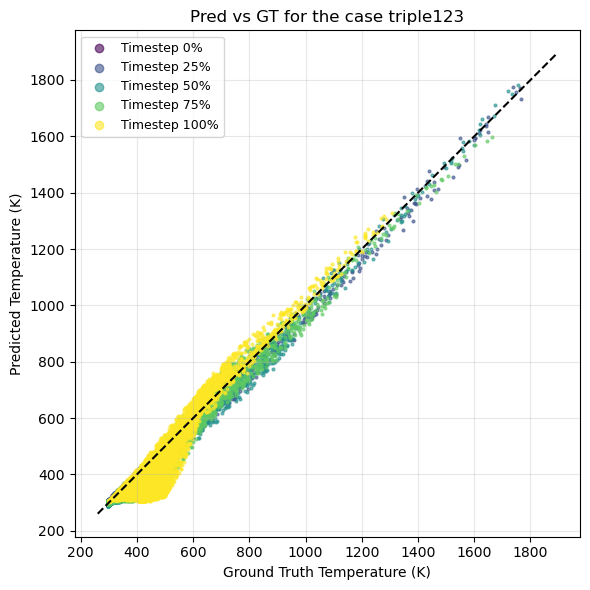

In [64]:
pred = triple123["pred"]
gt = triple123["gt"]
# selected_timesteps = [pred.shape[0]-1]
selected_timesteps = [0, int(pred.shape[0] * 0.25), int(pred.shape[0] * 0.5), int(pred.shape[0] * 0.75), pred.shape[0]-1]
plot_pred_vs_gt_selected(case_name, pred, gt, timesteps=selected_timesteps, cmap='viridis', point_size=4)

In [65]:
data = triple123

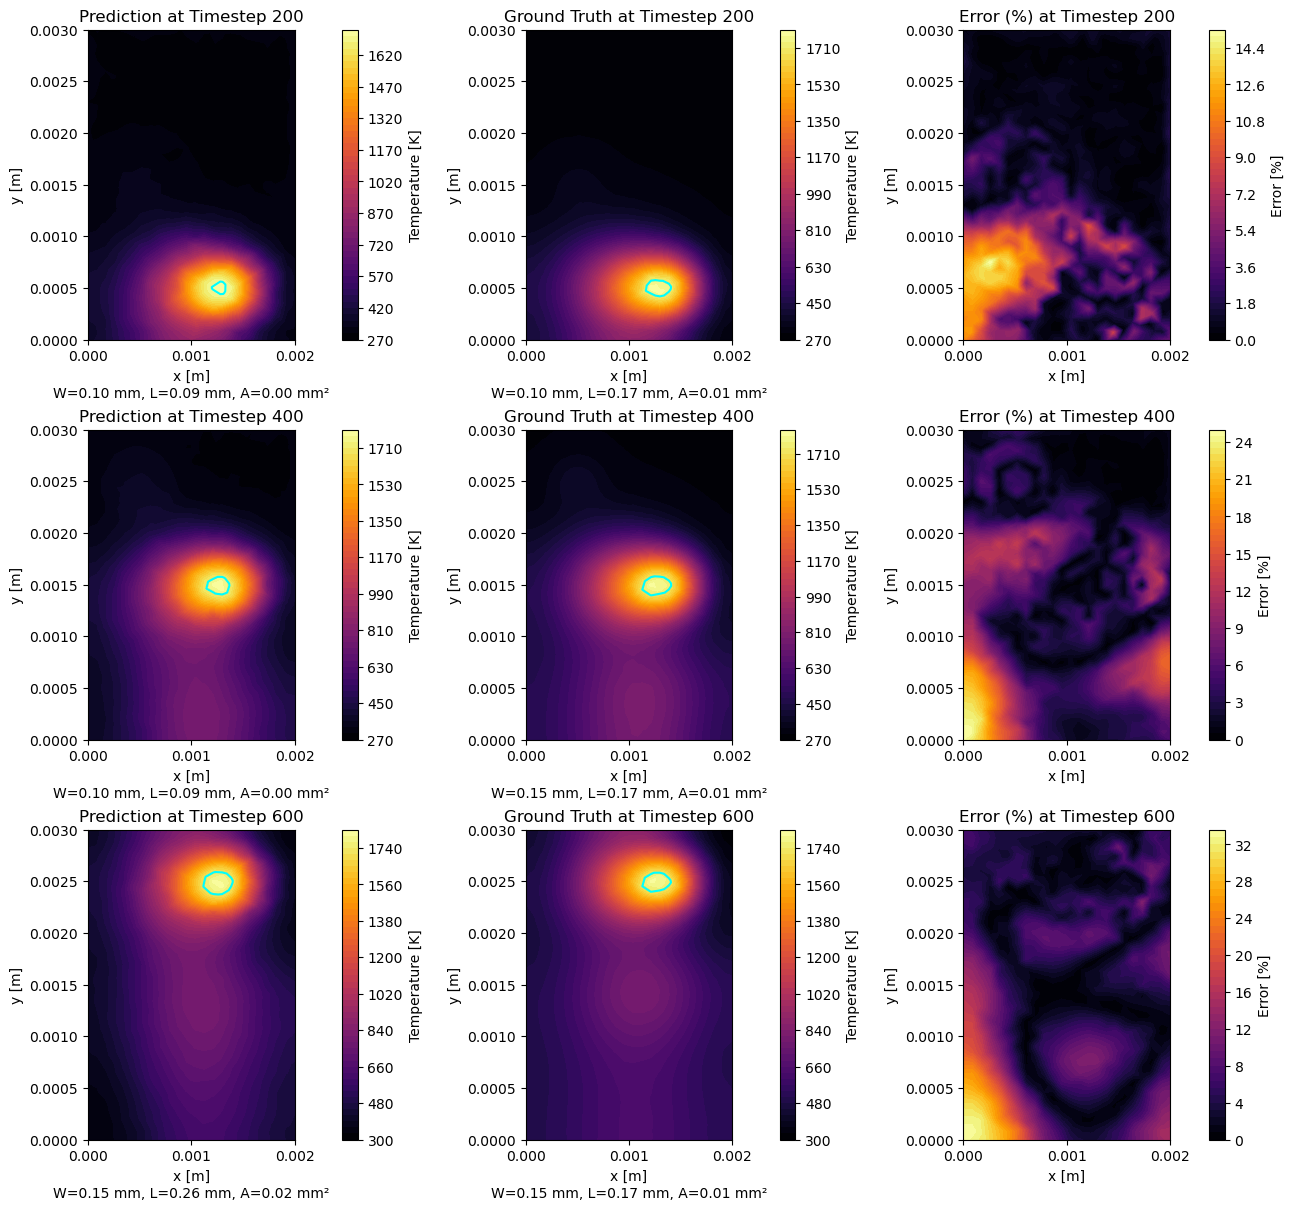

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# --- Parameters ---
timesteps = [200, 400, 600]  # timesteps for each row
melting_point = 1716  # K
pred = data["pred"]
gt = data["gt"]
mesh_pos = data["mesh_pos"]

# --- Top surface ---
top_mask = mesh_pos[:, 2] == np.max(mesh_pos[:, 2])
top_domain = mesh_pos[top_mask]
x, y = top_domain[:, 0], top_domain[:, 1]

# --- Melt pool metrics ---
def meltpool_metrics(temp, domain, mp_temp):
    mask = temp >= mp_temp
    if np.any(mask):
        mp_pts = domain[mask]
        width = np.max(mp_pts[:, 1]) - np.min(mp_pts[:, 1])  # y-direction
        length = np.max(mp_pts[:, 0]) - np.min(mp_pts[:, 0])  # x-direction
        if mp_pts.shape[0] >= 3:
            try:
                area = ConvexHull(mp_pts[:, :2]).volume
            except:
                area = 0
        else:
            area = 0
    else:
        width, length, area = 0, 0, 0
    return mask, width, length, area

# --- Plot function ---
def plot_meltpool(ax, temp, mask, title, width=None, length=None, area=None):
    cf = ax.tricontourf(x, y, temp, levels=50, cmap='inferno')
    ax.tricontour(x, y, temp, levels=[melting_point], colors='cyan', linewidths=1.5)
    ax.set_aspect('equal')
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_title(title)
    if width is not None and length is not None and area is not None:
        ax.text(0.5, -0.15,
                f"W={width*1e3:.2f} mm, L={length*1e3:.2f} mm, A={area*1e6:.2f} mm²",
                transform=ax.transAxes, ha='center', va='top', fontsize=10)
    return cf

# --- Create figure 3x3 ---
fig, axs = plt.subplots(len(timesteps), 3, figsize=(13, 12), constrained_layout=True)
colors = ['inferno']*3

for i, t in enumerate(timesteps):
    top_pred = pred[t, top_mask]
    top_gt = gt[t, top_mask]
    pred_mask, pred_width, pred_length, pred_area = meltpool_metrics(top_pred, top_domain, melting_point)
    gt_mask, gt_width, gt_length, gt_area = meltpool_metrics(top_gt, top_domain, melting_point)
    error_percent = 100 * np.abs(top_pred - top_gt) / np.maximum(np.abs(top_gt), 1e-8)

    # Column 1: Predicted
    cf1 = plot_meltpool(axs[i, 0], top_pred, pred_mask,
                        f"Prediction at Timestep {t}",
                        pred_width, pred_length, pred_area)
    fig.colorbar(cf1, ax=axs[i, 0], label="Temperature [K]")

    # Column 2: Ground Truth
    cf2 = plot_meltpool(axs[i, 1], top_gt, gt_mask,
                        f"Ground Truth at Timestep {t}",
                        gt_width, gt_length, gt_area)
    fig.colorbar(cf2, ax=axs[i, 1], label="Temperature [K]")

    # Column 3: Error %
    cf3 = axs[i, 2].tricontourf(x, y, error_percent, levels=50, cmap='inferno')
    axs[i, 2].set_aspect('equal')
    axs[i, 2].set_xlabel("x [m]")
    axs[i, 2].set_ylabel("y [m]")
    axs[i, 2].set_title(f"Error (%) at Timestep {t}")
    fig.colorbar(cf3, ax=axs[i, 2], label="Error [%]")

plt.show()


In [67]:
timestep = -1
mid_top_y = (mesh_pos[:, 1] ==  mesh_pos[:, 1]/2) & (mesh_pos[:, 2] ==  np.max(mesh_pos[:, 2]))
mid_top_line = mesh_pos[mid_top_y]
pred_mid_line = pred[timestep, mid_top_y]
gt_mid_line = gt[timestep, mid_top_y]

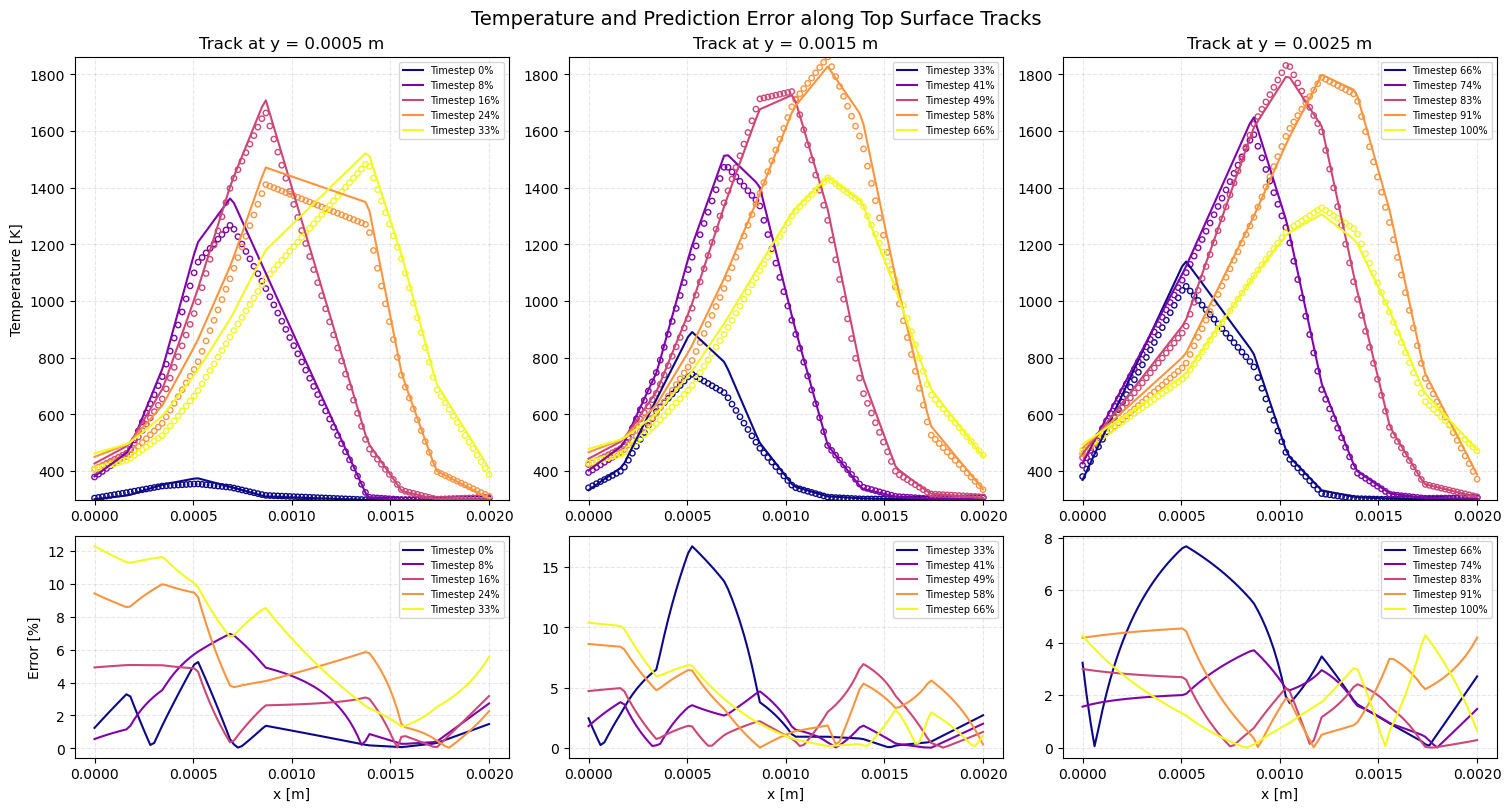

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.ticker import MaxNLocator

# --- Extract mesh and data ---
mesh_pos = data["mesh_pos"]
pred = data["pred"]
gt = data["gt"]

# --- Top surface coordinates ---
top_z = np.max(mesh_pos[:, 2])
L_y_min, L_y_max = np.min(mesh_pos[:, 1]), np.max(mesh_pos[:, 1])
track_positions = [L_y_min + f * (L_y_max - L_y_min) for f in [5/30, 15/30, 25/30]]

tol = 1e-8
x_min, x_max = np.min(mesh_pos[:, 0]), np.max(mesh_pos[:, 0])
x_interp = np.linspace(x_min, x_max, 100)

# --- Create figure (thinner bottom row) ---
fig, axs = plt.subplots(
    2, 3, figsize=(15, 8),
    gridspec_kw={'height_ratios': [2, 1]},  # thinner 2nd row
    constrained_layout=True
)

colors = plt.cm.plasma(np.linspace(0, 1, 5))

# For global y-limits on the top row
global_min, global_max = np.inf, -np.inf

# --- Precompute all interpolated data to find global y-limits ---
interp_data = []
for i, y_target in enumerate(track_positions):
    track_mask = (np.abs(mesh_pos[:, 1] - y_target) < tol) & (np.abs(mesh_pos[:, 2] - top_z) < tol)
    x_nodes = mesh_pos[track_mask, 0]
    timesteps_to_plot = np.linspace((pred.shape[0]-1)/3 * (i), (pred.shape[0]-1)/3 * (i+1), 5, dtype=int)
    
    for t in timesteps_to_plot:
        pred_vals = pred[t, track_mask]
        gt_vals = gt[t, track_mask]
        pred_interp = griddata(x_nodes, pred_vals, x_interp, method='linear')
        gt_interp = griddata(x_nodes, gt_vals, x_interp, method='linear')
        interp_data.append((i, t, pred_interp, gt_interp))
        global_min = min(global_min, np.nanmin([pred_interp, gt_interp]))
        global_max = max(global_max, np.nanmax([pred_interp, gt_interp]))

# --- Plot using precomputed data ---
for i, y_target in enumerate(track_positions):
    timesteps_to_plot = np.linspace((pred.shape[0]-1)/3 * (i), (pred.shape[0]-1)/3 * (i+1), 5, dtype=int)
    for color, (idx, t, pred_interp, gt_interp) in zip(colors, [d for d in interp_data if d[0] == i]):
        # --- Top row: Pred vs GT ---
        axs[0, i].scatter(x_interp, pred_interp, facecolors='none', edgecolors=color, s=15, linewidths=1)
        axs[0, i].plot(x_interp, gt_interp, color=color, linestyle='-', 
                       label=f"Timestep {int((t/(pred.shape[0]-1))*100)}%")

        # --- Bottom row: Error [%] ---
        error = np.abs(pred_interp - gt_interp) / np.maximum(gt_interp, 1e-8) * 100
        axs[1, i].plot(x_interp, error, color=color, linestyle='-', 
                       label=f"Timestep {int((t/(pred.shape[0]-1))*100)}%")

    # --- Style each column ---
    axs[0, i].set_title(f"Track at y = {y_target:.4f} m")
    axs[0, i].set_ylabel("Temperature [K]" if i == 0 else "")
    axs[1, i].set_ylabel("Error [%]" if i == 0 else "")
    axs[1, i].set_xlabel("x [m]")

    # Coarse tick marks
    axs[1, i].xaxis.set_major_locator(MaxNLocator(nbins=5))
    axs[0, i].xaxis.set_major_locator(MaxNLocator(nbins=5))

    # Grid + legends
    axs[0, i].grid(True, linestyle='--', alpha=0.3)
    axs[1, i].grid(True, linestyle='--', alpha=0.3)
    axs[0, i].legend(fontsize=7, loc='best')
    axs[1, i].legend(fontsize=7, loc='best')

# --- Apply uniform y-limits to first row ---
for ax in axs[0, :]:
    ax.set_ylim(global_min, global_max)

# --- Global title ---
fig.suptitle("Temperature and Prediction Error along Top Surface Tracks", fontsize=14)
plt.show()


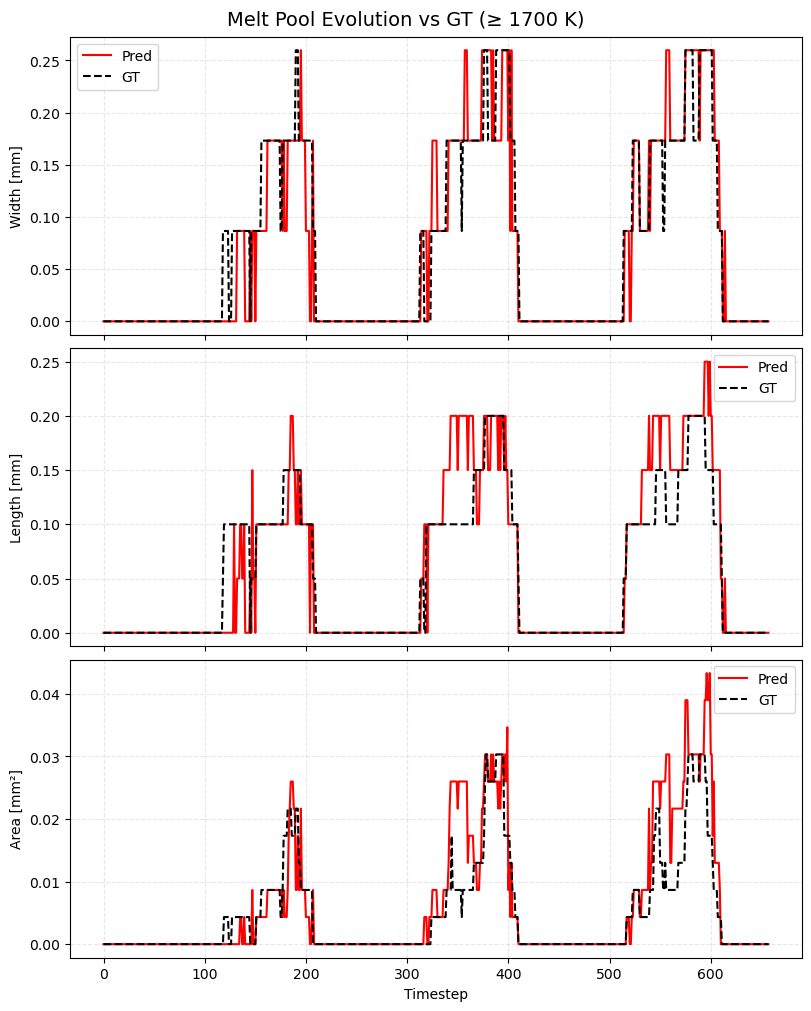

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# --- Inputs ---
melting_point = 1700  # [K]
pred = data["pred"]
gt = data["gt"]
mesh_pos = data["mesh_pos"]

# --- Extract top surface ---
top_mask = mesh_pos[:, 2] == np.max(mesh_pos[:, 2])
top_domain = mesh_pos[top_mask]
x, y = top_domain[:, 0], top_domain[:, 1]

# --- Containers for results ---
pred_widths, pred_lengths, pred_areas = [], [], []
gt_widths, gt_lengths, gt_areas = [], [], []

# --- Loop through timesteps ---
for t in range(pred.shape[0]):
    # Predicted
    top_temp_pred = pred[t, top_mask]
    melt_mask_pred = top_temp_pred >= melting_point
    if np.any(melt_mask_pred):
        melt_pts = top_domain[melt_mask_pred]
        width = np.max(melt_pts[:, 0]) - np.min(melt_pts[:, 0])
        length = np.max(melt_pts[:, 1]) - np.min(melt_pts[:, 1])
        if melt_pts.shape[0] >= 3:
            try:
                area = ConvexHull(melt_pts[:, :2]).volume
            except:
                area = 0
        else:
            area = 0
    else:
        width, length, area = 0, 0, 0
    pred_widths.append(width)
    pred_lengths.append(length)
    pred_areas.append(area)
    
    # Ground truth
    top_temp_gt = gt[t, top_mask]
    melt_mask_gt = top_temp_gt >= melting_point
    if np.any(melt_mask_gt):
        melt_pts = top_domain[melt_mask_gt]
        width = np.max(melt_pts[:, 0]) - np.min(melt_pts[:, 0])
        length = np.max(melt_pts[:, 1]) - np.min(melt_pts[:, 1])
        if melt_pts.shape[0] >= 3:
            try:
                area = ConvexHull(melt_pts[:, :2]).volume
            except:
                area = 0
        else:
            area = 0
    else:
        width, length, area = 0, 0, 0
    gt_widths.append(width)
    gt_lengths.append(length)
    gt_areas.append(area)

# Convert to arrays
pred_widths = np.array(pred_widths)
pred_lengths = np.array(pred_lengths)
pred_areas = np.array(pred_areas)
gt_widths = np.array(gt_widths)
gt_lengths = np.array(gt_lengths)
gt_areas = np.array(gt_areas)

# --- Plot melt pool metrics over time ---
timesteps = np.arange(pred.shape[0])

fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True, constrained_layout=True)

# Width
axs[0].plot(timesteps, pred_widths*1e3, 'r-', lw=1.5, label="Pred")
axs[0].plot(timesteps, gt_widths*1e3, 'k--', lw=1.5, label="GT")
axs[0].set_ylabel("Width [mm]")
axs[0].grid(True, linestyle='--', alpha=0.3)
axs[0].legend()

# Length
axs[1].plot(timesteps, pred_lengths*1e3, 'r-', lw=1.5, label="Pred")
axs[1].plot(timesteps, gt_lengths*1e3, 'k--', lw=1.5, label="GT")
axs[1].set_ylabel("Length [mm]")
axs[1].grid(True, linestyle='--', alpha=0.3)
axs[1].legend()

# Area
axs[2].plot(timesteps, pred_areas*1e6, 'r-', lw=1.5, label="Pred")
axs[2].plot(timesteps, gt_areas*1e6, 'k--', lw=1.5, label="GT")
axs[2].set_ylabel("Area [mm²]")
axs[2].set_xlabel("Timestep")
axs[2].grid(True, linestyle='--', alpha=0.3)
axs[2].legend()

fig.suptitle(f"Melt Pool Evolution vs GT (≥ {melting_point} K)", fontsize=14)
plt.show()
